In [1]:
import nltk
from nltk.tokenize import word_tokenize
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot') #Setting style sheets that we're using for plot
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
calls = pd.read_csv('calls.csv')
customers = pd.read_csv('customers.csv')
reason = pd.read_csv('reason.csv')
sentiment = pd.read_csv('sentiment_statisticsc.csv')
test = pd.read_csv('test.csv')

In [3]:
reason.head()

,call_id,primary_call_reason
0,4667960400,Voluntary Cancel
1,1122072124,Booking
2,6834291559,IRROPS
3,2266439882,Upgrade
4,1211603231,Seating


In [4]:
reason['primary_call_reason'].value_counts()

IRROPS                     13057
Voluntary Change           10291
Seating                     6223
Mileage Plus                5487
Post-Flight                 3869
Communications              3779
Products and Services       2792
Upgrade                     2682
Baggage                     2616
Booking                     2589
Checkout                    1840
Check-In                    1490
Voluntary Cancel            1304
Digital Support              996
ETC                          930
Traveler Updates             772
Schedule Change              707
Other Topics                 568
Products & Services          476
Disability                   394
Check In                     385
Post Flight                  373
Voluntary  Cancel            278
IRROPS                       254
Other  Topics                234
Voluntary Change             208
Voluntary   Change           200
Voluntary  Change            149
Seating                      142
Digital   Support            136
Mileage  P

In [5]:
sentiment.head()


,call_id,agent_id,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,963118,neutral,angry,-0.04,0.39
1,1122072124,519057,calm,neutral,0.02,0.35
2,6834291559,158319,neutral,polite,-0.13,0.32
3,2266439882,488324,neutral,frustrated,-0.20,0.20
4,1211603231,721730,neutral,polite,-0.05,0.35


In [6]:
sentiment_df = sentiment.groupby('agent_tone')['average_sentiment'].mean().reset_index()
sentiment_df

,agent_tone,average_sentiment
0,angry,-0.616478
1,calm,0.101289
2,frustrated,-0.329978
3,neutral,-0.080355
4,polite,0.673793


In [7]:
sentiment['agent_tone'].value_counts()

neutral       42758
calm          24675
frustrated     3684
angry           389
polite           87
Name: agent_tone, dtype: int64

In [8]:
sentiment['customer_tone'].value_counts()

neutral       14444
angry         14408
polite        14371
calm          14347
frustrated    14240
Name: customer_tone, dtype: int64

In [9]:
calls_shape = calls.shape
customers_shape = customers.shape
reason_shape = reason.shape
sentiment_shape = sentiment.shape

In [10]:
print(calls_shape)
print(customers_shape)
print(reason_shape)
print(sentiment_shape)

(71810, 7)
(71810, 3)
(66653, 2)
(71810, 6)


In [11]:
calls.tail()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript
71805,1563273072,8022667294,413148,8/31/2024 23:48,8/31/2024 23:57,9/1/2024 0:25,\n\nAgent: Thank you for calling United Airlin...
71806,8865997781,4474867021,980156,8/31/2024 23:55,8/31/2024 23:58,9/1/2024 0:06,\n\nAgent: Thank you for calling United Airlin...
71807,8019240181,9762042472,616988,8/31/2024 23:52,8/31/2024 23:58,9/1/2024 0:04,\n\nAgent: Thank you for calling United Airlin...
71808,8332067080,8095620266,161354,8/31/2024 23:53,8/31/2024 23:59,9/1/2024 0:03,\n\nAgent: Thank you for calling United Airlin...
71809,8210720833,8014388758,547592,8/31/2024 23:49,8/31/2024 23:59,9/1/2024 0:02,\n\nAgent: Thank you for calling United Airlin...


In [12]:
sentiment.tail()

,call_id,agent_id,agent_tone,customer_tone,average_sentiment,silence_percent_average
71805,1563273072,413148,calm,calm,0.05,0.34
71806,8865997781,980156,calm,frustrated,0.03,0.22
71807,8019240181,616988,calm,polite,0.05,0.42
71808,8332067080,161354,neutral,polite,-0.07,0.13
71809,8210720833,547592,neutral,calm,0.00,0.10


In [13]:
reason_df = reason

In [14]:
reason_df.head()

,call_id,primary_call_reason
0,4667960400,Voluntary Cancel
1,1122072124,Booking
2,6834291559,IRROPS
3,2266439882,Upgrade
4,1211603231,Seating


In [15]:
reason_df['primary_call_reason'] = (reason_df['primary_call_reason']
                .str.lower()                                  # Convert to lowercase
                .str.strip()                                  # Remove leading and trailing spaces
                .str.replace(r'\s+', ' ', regex=True))

In [16]:
reason_df['primary_call_reason'].value_counts()

irrops                   13311
voluntary change         10848
seating                   6365
mileage plus              5851
post-flight               3957
communications            3840
products and services     2856
baggage                   2832
upgrade                   2738
booking                   2637
checkout                  1888
voluntary cancel          1607
check-in                  1519
digital support           1225
etc                        952
traveler updates           937
other topics               818
schedule change            731
products & services        476
disability                 403
check in                   385
post flight                373
unaccompanied minor        104
Name: primary_call_reason, dtype: int64

In [17]:
from wordcloud import WordCloud

In [18]:
calls.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript
0,4667960400,2033123310,963118,7/31/2024 23:56,8/1/2024 0:03,8/1/2024 0:34,\n\nAgent: Thank you for calling United Airlin...
1,1122072124,8186702651,519057,8/1/2024 0:03,8/1/2024 0:06,8/1/2024 0:18,\n\nAgent: Thank you for calling United Airlin...
2,6834291559,2416856629,158319,7/31/2024 23:59,8/1/2024 0:07,8/1/2024 0:26,\n\nAgent: Thank you for calling United Airlin...
3,2266439882,1154544516,488324,8/1/2024 0:05,8/1/2024 0:10,8/1/2024 0:17,\n\nAgent: Thank you for calling United Airlin...
4,1211603231,5214456437,721730,8/1/2024 0:04,8/1/2024 0:14,8/1/2024 0:23,\n\nAgent: Thank you for calling United Airlin...


In [19]:
calls.shape

(71810, 7)

In [21]:
calls['call_start_datetime'] = pd.to_datetime(calls['call_start_datetime'])
calls['call_end_datetime'] = pd.to_datetime(calls['call_end_datetime'])
calls['agent_assigned_datetime'] = pd.to_datetime(calls['agent_assigned_datetime'])

In [22]:
calls['Handle_Time'] = calls['call_end_datetime'] - calls['agent_assigned_datetime']
calls['Waiting_Time'] = calls['agent_assigned_datetime'] - calls['call_start_datetime']


In [23]:
calls.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:31:00,0 days 00:07:00
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:12:00,0 days 00:03:00
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:19:00,0 days 00:08:00
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:07:00,0 days 00:05:00
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:09:00,0 days 00:10:00


In [25]:
# Define the maximum duration limit of 23:59:59
max_duration = pd.Timedelta(hours=23, minutes=59, seconds=59)

# Filter the DataFrame to find calls with duration longer than 23:59:59
long_calls = calls[calls['Handle_Time'] > max_duration]

# Display the long calls, if any
print(long_calls)

Empty DataFrame
Columns: [call_id, customer_id, agent_id, call_start_datetime, agent_assigned_datetime, call_end_datetime, call_transcript, Handle_Time, Waiting_Time]
Index: []


In [26]:
calls['Handle_Time'] = calls['Handle_Time'].apply(lambda x: str(x).replace('0 days ', '') if '0 days' in str(x) else str(x))
calls['Waiting_Time'] = calls['Waiting_Time'].apply(lambda x: str(x).replace('0 days ', '') if '0 days' in str(x) else str(x))

In [27]:
calls.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,00:31:00,00:07:00
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,00:12:00,00:03:00
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,00:19:00,00:08:00
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,00:07:00,00:05:00
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,00:09:00,00:10:00


# AHT (Average Handle Time) and AST(Average Speed to Answer)

In [29]:
calls['Handle_Time'] = pd.to_timedelta(calls['Handle_Time'])
tt_handle_time = calls['Handle_Time'].sum()

calls['Waiting_Time'] = pd.to_timedelta(calls['Waiting_Time'])
tt_waiting_time = calls['Waiting_Time'].sum()

In [30]:
time_delta_1 = pd.Timedelta(tt_handle_time)
time_delta_2 = pd.Timedelta(tt_waiting_time)

# Convert the timedelta to total minutes
total_handle_time = time_delta_1.total_seconds() / 60
total_waiting_time = time_delta_2.total_seconds() / 60

# Display the total minutes
print(f"Total Handle Time: {total_handle_time}")
print(f"Total Waiting Time: {total_waiting_time}")

Total Handle Time: 834251.0
Total Waiting Time: 523097.0


In [31]:
Total_calls = calls['call_id'].count()

AHT = round((total_handle_time/Total_calls), 1)
AST = round((total_waiting_time/Total_calls), 1)

print(f"AHT: {AHT}")
print(f"AST: {AST}")

AHT: 11.6
AST: 7.3


In [32]:
calls_sentiment = pd.merge(calls, sentiment, on='call_id', how='outer')
calls_sentiment = calls_sentiment.drop(columns=['agent_id_y'])
calls_sentiment.rename(columns={'agent_id_x': 'agent_id'}, inplace=True)
calls_sentiment.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,Handle_Time,Waiting_Time,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:31:00,0 days 00:07:00,neutral,angry,-0.04,0.39
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:12:00,0 days 00:03:00,calm,neutral,0.02,0.35
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:19:00,0 days 00:08:00,neutral,polite,-0.13,0.32
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:07:00,0 days 00:05:00,neutral,frustrated,-0.20,0.20
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,0 days 00:09:00,0 days 00:10:00,neutral,polite,-0.05,0.35


In [39]:
calls_sentiment['Handle_Time'] = pd.to_numeric(
    calls_sentiment['Handle_Time'])
calls_sentiment['Waiting_Time'] = pd.to_numeric(
    calls_sentiment['Waiting_Time'])

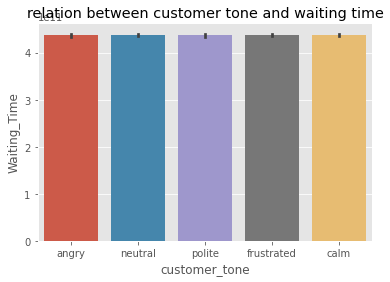

In [40]:
ax = sns.barplot(data=calls_sentiment, x='customer_tone', y='Waiting_Time')
ax.set_title('relation between customer tone and waiting time')
plt.show()

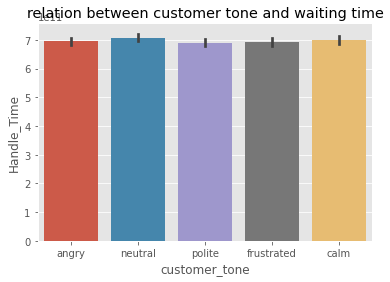

In [41]:
ax = sns.barplot(data=calls_sentiment, x='customer_tone', y='Handle_Time')
ax.set_title('relation between customer tone and waiting time')
plt.show()

In [45]:
correlation = calls_sentiment['silence_percent_average'].corr(calls_sentiment['average_sentiment'])

print("Pearson correlation between silence and average_sentiment:", correlation)

Pearson correlation between silence and average_sentiment: 0.03533890574144503


In [46]:
categorical_columns = ['agent_tone', 'customer_tone']
calls_sentiment_encoded = pd.get_dummies(calls_sentiment, columns=categorical_columns)

In [52]:
correlation_matrix = calls_sentiment[[
    'Handle_Time','Waiting_Time', 'agent_tone', 'customer_tone', 
    'average_sentiment', 'silence_percent_average']].corr()
correlation_matrix

,Handle_Time,Waiting_Time,average_sentiment,silence_percent_average
Handle_Time,1.000000,-0.027778,-0.076065,0.406883
Waiting_Time,-0.027778,1.000000,0.039881,-0.012068
average_sentiment,-0.076065,0.039881,1.000000,0.035339
silence_percent_average,0.406883,-0.012068,0.035339,1.000000


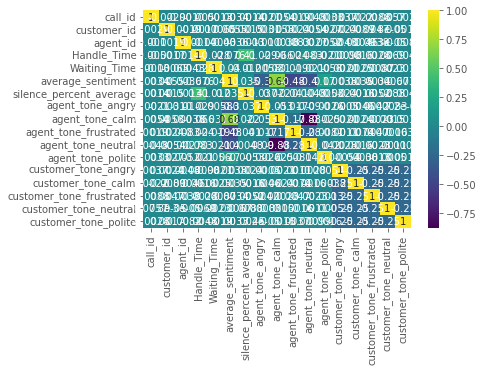

In [49]:
sns.heatmap(correlation_matrix, annot=True, cmap="viridis")
plt.show()

In [55]:
calls_sentiment['agent_tone'].value_counts().to_frame()

,agent_tone
neutral,42758
calm,24675
frustrated,3684
angry,389
polite,87


In [56]:
calls_sentiment['customer_tone'].value_counts().to_frame()

,customer_tone
neutral,14444
angry,14408
polite,14371
calm,14347
frustrated,14240


In [68]:
categorical_columns = ['agent_tone', 'customer_tone']
numeric_columns = ['average_sentiment', 'silence_percent_average']

# One-hot encode the categorical columns
df_encoded = pd.get_dummies(calls_sentiment, columns=categorical_columns)

# Calculate Pearson correlation (consider encoding other numeric columns if needed)
correlation_matrix = df_encoded.corr()


In [65]:
correlation_matrix

,call_id,customer_id,agent_id,Handle_Time,Waiting_Time,average_sentiment,silence_percent_average,agent_tone_angry,agent_tone_calm,agent_tone_frustrated,agent_tone_neutral,agent_tone_polite
call_id,1.000000,-0.002907,-0.001021,-0.005040,-0.001266,-0.003442,-0.001415,-0.002078,-0.005403,0.001938,0.004834,-0.003292
customer_id,-0.002907,1.000000,-0.001942,-0.001668,-0.000648,0.005481,0.001525,-0.003138,0.005827,0.002351,-0.005411,0.002681
agent_id,-0.001021,-0.001942,1.000000,0.001431,-0.000426,-0.003600,-0.001269,-0.010449,-0.000382,0.008301,-0.002659,0.005227
Handle_Time,-0.005040,-0.001668,0.001431,1.000000,-0.027778,-0.076065,0.406883,-0.028847,-0.065923,-0.024020,0.083397,-0.021458
Waiting_Time,-0.001266,-0.000648,-0.000426,-0.027778,1.000000,0.039881,-0.012068,-0.005849,0.030931,-0.019496,-0.021063,0.005603
average_sentiment,-0.003442,0.005481,-0.003600,-0.076065,0.039881,1.000000,0.035339,-0.299593,0.679474,-0.480083,-0.396116,0.171542
silence_percent_average,-0.001415,0.001525,-0.001269,0.406883,-0.012068,0.035339,1.000000,-0.036679,0.022207,-0.041390,0.004812,-0.005253
agent_tone_angry,-0.002078,-0.003138,-0.010449,-0.028847,-0.005849,-0.299593,-0.036679,1.000000,-0.053397,-0.017162,-0.089533,-0.002570
agent_tone_calm,-0.005403,0.005827,-0.000382,-0.065923,0.030931,0.679474,0.022207,-0.053397,1.000000,-0.168252,-0.877763,-0.025199
agent_tone_frustrated,0.001938,0.002351,0.008301,-0.024020,-0.019496,-0.480083,-0.041390,-0.017162,-0.168252,1.000000,-0.282114,-0.008099


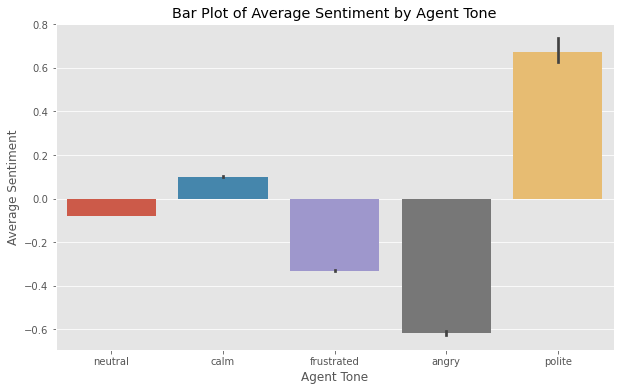

In [73]:
plt.figure(figsize=(10, 6))
sns.barplot(x='agent_tone', y='average_sentiment', data=calls_sentiment)
plt.title('Bar Plot of Average Sentiment by Agent Tone')
plt.xlabel('Agent Tone')
plt.ylabel('Average Sentiment')
plt.show()

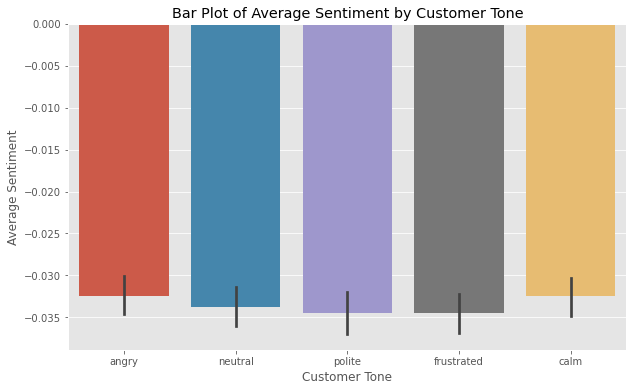

In [74]:
plt.figure(figsize=(10, 6))
sns.barplot(x='customer_tone', y='average_sentiment', data=calls_sentiment)
plt.title('Bar Plot of Average Sentiment by Customer Tone')
plt.xlabel('Customer Tone')
plt.ylabel('Average Sentiment')
plt.show()